In [1]:
import numpy as np 
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

In [3]:
z = np.linspace(-5, 5, 200)

In [4]:
z

array([-5.        , -4.94974874, -4.89949749, -4.84924623, -4.79899497,
       -4.74874372, -4.69849246, -4.64824121, -4.59798995, -4.54773869,
       -4.49748744, -4.44723618, -4.39698492, -4.34673367, -4.29648241,
       -4.24623116, -4.1959799 , -4.14572864, -4.09547739, -4.04522613,
       -3.99497487, -3.94472362, -3.89447236, -3.84422111, -3.79396985,
       -3.74371859, -3.69346734, -3.64321608, -3.59296482, -3.54271357,
       -3.49246231, -3.44221106, -3.3919598 , -3.34170854, -3.29145729,
       -3.24120603, -3.19095477, -3.14070352, -3.09045226, -3.04020101,
       -2.98994975, -2.93969849, -2.88944724, -2.83919598, -2.78894472,
       -2.73869347, -2.68844221, -2.63819095, -2.5879397 , -2.53768844,
       -2.48743719, -2.43718593, -2.38693467, -2.33668342, -2.28643216,
       -2.2361809 , -2.18592965, -2.13567839, -2.08542714, -2.03517588,
       -1.98492462, -1.93467337, -1.88442211, -1.83417085, -1.7839196 ,
       -1.73366834, -1.68341709, -1.63316583, -1.58291457, -1.53

> Vanishing gradients caused when an area becomes too saturated with values.

> Exploding gradients caused when they move too quickly over gradient and can never converge.

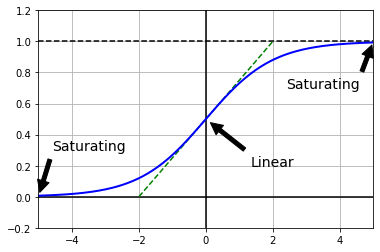

In [5]:
plt.plot([-5, 5], [0, 0], 'k-') # bottom solid
plt.plot([-5, 5], [1, 1], 'k--') # top dashed
plt.plot([0, 0], [-0.2, 1.2], 'k-') # vertical line solid
plt.plot([-2, 2], [0, 1], 'g--') # dashed tangent
plt.plot(z, logit(z), "b-", linewidth=2) # sigmoid graph
props = dict(facecolor='black', shrink=0.1) # dict for objects to place
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center") # add arrows
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2]) # set zoom
plt.show()

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [7]:
[name for name in dir(keras.activations) if not name.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [8]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [9]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

# LeakyReLU

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

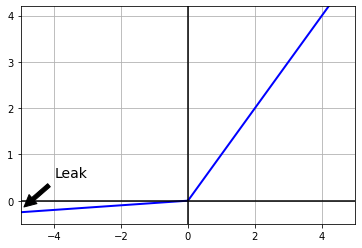

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2) # relu graph
plt.plot([-5, 5], [0, 0], 'k-') # x axis
plt.plot([0, 0], [-0.5, 4.2], 'k-') # y axis
plt.grid(True)
props = dict(facecolor='black', shrink=0.1) # dict for objects to play
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center") # placing arrow
plt.axis([-5, 5, -0.5, 4.2]) # set zoom
plt.show()

# ELU

In [12]:
def elu(z, a=1):
    return np.where(z < 0, a * (np.exp(z) - 1), z)

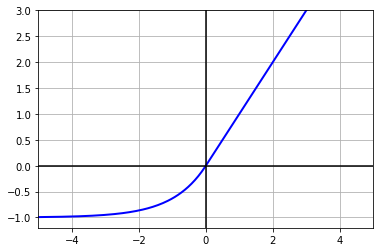

In [13]:
plt.plot(z, elu(z, 1), "b-", linewidth=2) # elu graph, if alpha=1 it is smooth everywhere
plt.plot([-5, 5], [0, 0], 'k-') # x axis
plt.plot([0, 0], [-1.2, 3], 'k-') # y axis
plt.grid(True)
plt.axis([-5, 5, -1.2, 3]) # set zoom
plt.show()

# SELU

In [14]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [15]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

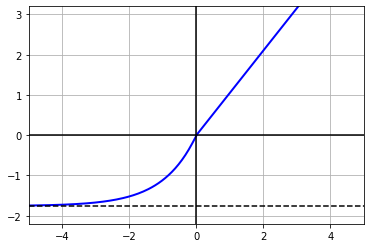

In [16]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

# SELU (Impletementation)

> All layers must be dense.

> Input layers must be standardized.

> Hidden layers must be init with LeCun.

> Architecture must be Sequiental.


In [17]:
keras.backend.clear_session()

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(2):
    model.add(keras.layers.Dense(300, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

2022-12-02 15:08:28.017271: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])

In [21]:
(xtf, ytf), (xte, yte) = keras.datasets.fashion_mnist.load_data()
xtf = xtf / 255.0
xte = xte / 255.0
xv, xt = xtf[:5000], xtf[5000:]
yv, yt = ytf[:5000], ytf[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [22]:
pixel_means = xt.mean(axis=0, keepdims=True) # scale in terms of std = ((x / u) / std)
pixel_stds = xt.std(axis=0, keepdims=True)
xts = (xt - pixel_means) / pixel_stds
xvs = (xv - pixel_means) / pixel_stds
xtes = (xte - pixel_means) / pixel_stds

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(xts, yt, epochs=100,
                    validation_data=(xvs, yv),
                    callbacks=[early_stopping_cb])

2022-12-02 15:08:33.286380: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4885 - accuracy: 0.8287 - val_loss: 0.4150 - val_accuracy: 0.8628
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3788 - accuracy: 0.8636 - val_loss: 0.3777 - val_accuracy: 0.8656
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3426 - accuracy: 0.8764 - val_loss: 0.3838 - val_accuracy: 0.8640
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3189 - accuracy: 0.8849 - val_loss: 0.3595 - val_accuracy: 0.8726
Epoch 5/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2988 - accuracy: 0.8918 - val_loss: 0.3490 - val_accuracy: 0.8724
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2821 - accuracy: 0.8979 - val_loss: 0.3371 - val_accuracy: 0.8808
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2689 - accuracy: 0.9027 - val_loss: 0.3445 - val_ac

In [24]:
model.evaluate(xtes, yte)

313/313 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8841


[0.34259533882141113, 0.8841000199317932]

In [25]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

> Add LeakyRelu after the layer you intend to have it.

> he_normal works best with ReLU

In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=.02)
])

# Batch Normalization

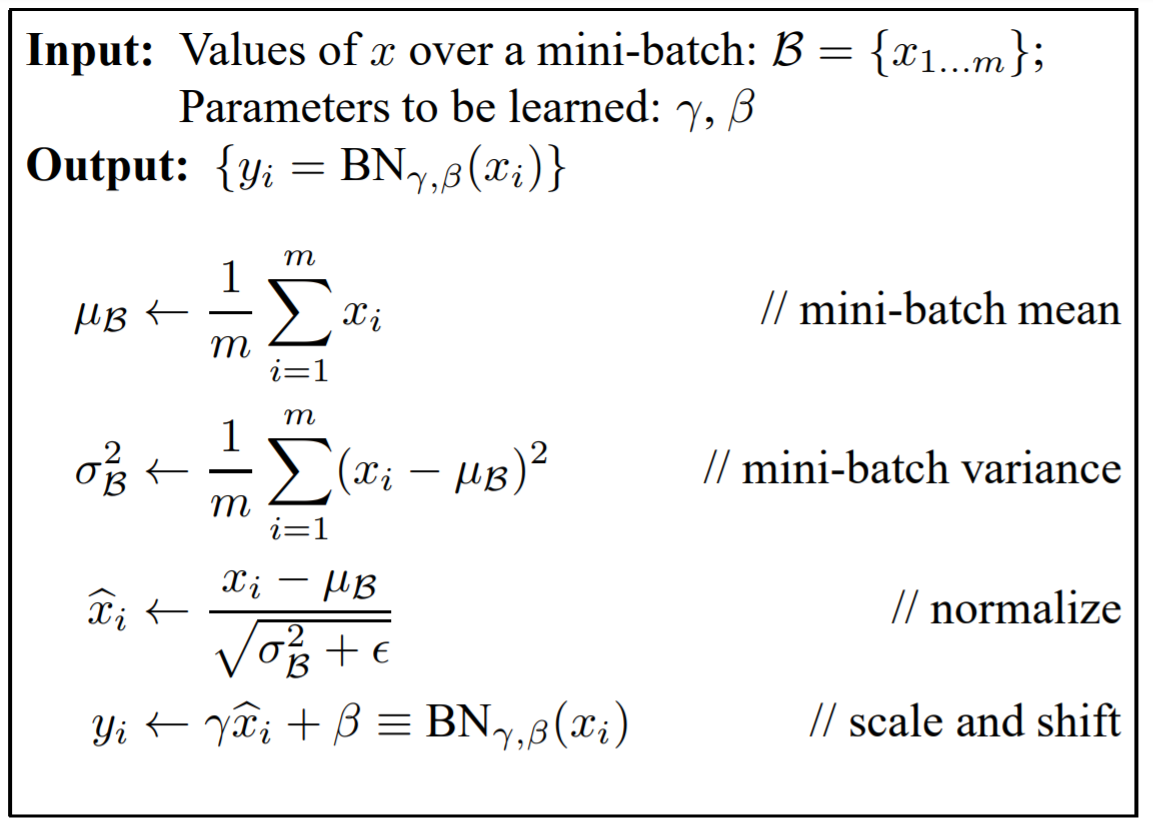

> beta and gamma are learnt alongside weights and biases, hence the longer compute time (more computations with activations, more computations during backpropogation)

> (standard deviation is average of varience, i forgot)

In [27]:
keras.backend.clear_session()

> After Activation

In [28]:
model_after = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, "elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, "elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

> Before Activation

> Remove Bias becuase of the added B

In [29]:
model_before = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [30]:
model_before.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 300)              

> Adds ( 1200 ) params over same model above without BN (means/stndev are non-trainable)

In [31]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[]

> v' = v' * momentum + v(1 - mementum)

# Model Runtime Comparison

In [32]:
model_before.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])

In [33]:
history = model_before.fit(xt, yt, epochs=100,
                    validation_data=(xv, yv),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5576 - accuracy: 0.8054 - val_loss: 0.4208 - val_accuracy: 0.8540
Epoch 2/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4301 - accuracy: 0.8471 - val_loss: 0.3878 - val_accuracy: 0.8634
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3965 - accuracy: 0.8601 - val_loss: 0.3644 - val_accuracy: 0.8720
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3729 - accuracy: 0.8675 - val_loss: 0.3578 - val_accuracy: 0.8770
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3556 - accuracy: 0.8726 - val_loss: 0.3420 - val_accuracy: 0.8802
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3388 - accuracy: 0.8790 - val_loss: 0.3431 - val_accuracy: 0.8814
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3292 - accuracy: 0.8819 - val_loss: 0.3412 - val_

In [34]:
model_before.evaluate(xte, yte)

313/313 [==============================] - 1s 2ms/step - loss: 0.3286 - accuracy: 0.8878


[0.32863742113113403, 0.8877999782562256]

In [35]:
keras.backend.clear_session()

In [36]:
model_after.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])

In [37]:
history = model_after.fit(xt, yt, epochs=100,
                    validation_data=(xv, yv),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5280 - accuracy: 0.8163 - val_loss: 0.3917 - val_accuracy: 0.8614
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4115 - accuracy: 0.8530 - val_loss: 0.3610 - val_accuracy: 0.8694
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3751 - accuracy: 0.8657 - val_loss: 0.3549 - val_accuracy: 0.8742
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3492 - accuracy: 0.8755 - val_loss: 0.3367 - val_accuracy: 0.8816
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3345 - accuracy: 0.8787 - val_loss: 0.3342 - val_accuracy: 0.8790
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3199 - accuracy: 0.8848 - val_loss: 0.3240 - val_accuracy: 0.8834
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3036 - accuracy: 0.8900 - val_loss: 0.3187 - val_ac

In [38]:
model_after.evaluate(xte, yte)

313/313 [==============================] - 1s 2ms/step - loss: 0.3300 - accuracy: 0.8818


[0.32997339963912964, 0.8817999958992004]

In [39]:
# class BatchNormalization(keras.layers.Layer):
#    def call(self, inputs, training=None):
#        pass

# Gradient Clipping

In [40]:
keras.backend.clear_session()

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

> [-.9, 100] -> [-.9, 1.0] == clipvalue == can change direction of gradient (being less left skewed)

> [-.9, 100] -> [-.0089, 0.9999] == clipnorm == can change direction of gradient (being less left skewed)

# Reusing Pretrained Layers

In [42]:
def split_dataset(x, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((x[~y_5_or_6], y_A),
            (x[y_5_or_6], y_B))

(xta, yta), (xtb, ytb) = split_dataset(xt, yt)
(xva, yva), (xvb, yvb) = split_dataset(xv, yv)
(xtea, ytea), (xteb, yteb) = split_dataset(xte, yte)
xtb = xtb[:200]
ytb = ytb[:200]

In [43]:
xta.shape

(43986, 28, 28)

In [44]:
xtb.shape

(200, 28, 28)

In [45]:
yta[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [46]:
ytb[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [47]:
modela = keras.models.Sequential()
modela.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    modela.add(keras.layers.Dense(n_hidden, activation="selu"))
modela.add(keras.layers.Dense(8, activation="softmax"))

In [48]:
modela.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [49]:
history = modela.fit(xta, yta, epochs=20,
                    validation_data=(xva, yva))

Epoch 1/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.5920 - accuracy: 0.8108 - val_loss: 0.3716 - val_accuracy: 0.8819
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3528 - accuracy: 0.8793 - val_loss: 0.3299 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3144 - accuracy: 0.8911 - val_loss: 0.2917 - val_accuracy: 0.9031
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2941 - accuracy: 0.8981 - val_loss: 0.2781 - val_accuracy: 0.9078
Epoch 5/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2804 - accuracy: 0.9023 - val_loss: 0.2730 - val_accuracy: 0.9101
Epoch 6/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2704 - accuracy: 0.9063 - val_loss: 0.2631 - val_accuracy: 0.9136
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2625 - accuracy: 0.9096 - val_loss: 0.2568 - val_accuracy:

In [50]:
modela.save("selu_8_class.h5")

In [51]:
modelb = keras.models.Sequential()
modelb.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    modelb.add(keras.layers.Dense(n_hidden, activation="selu"))
modelb.add(keras.layers.Dense(1, activation="sigmoid"))

In [52]:
modelb.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [53]:
history = modelb.fit(xtb, ytb, epochs=20,
                      validation_data=(xvb, yvb))

Epoch 1/20
7/7 [==============================] - 1s 51ms/step - loss: 0.6542 - accuracy: 0.6450 - val_loss: 0.5617 - val_accuracy: 0.7292
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 0.4841 - accuracy: 0.8100 - val_loss: 0.4391 - val_accuracy: 0.8093
Epoch 3/20
7/7 [==============================] - 0s 21ms/step - loss: 0.3747 - accuracy: 0.8900 - val_loss: 0.3683 - val_accuracy: 0.8550
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 0.3066 - accuracy: 0.9450 - val_loss: 0.3169 - val_accuracy: 0.8955
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2574 - accuracy: 0.9550 - val_loss: 0.2785 - val_accuracy: 0.9168
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2207 - accuracy: 0.9650 - val_loss: 0.2482 - val_accuracy: 0.9331
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.1918 - accuracy: 0.9650 - val_loss: 0.2249 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [54]:
modelaclone = keras.models.clone_model(modela)
modelaclone.set_weights(modela.get_weights())
modelba = keras.models.Sequential(modelaclone.layers[:-1])
modelba.add(keras.layers.Dense(1, activation="sigmoid"))

In [55]:
for layer in modelba.layers[:-1]:
    layer.trainable = False

modelba.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [56]:
history = modelba.fit(xtb, ytb, epochs=4,
                           validation_data=(xvb, yvb))

for layer in modelba.layers[:-1]:
    layer.trainable = True

modelba.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = modelba.fit(xtb, ytb, epochs=16,
                           validation_data=(xvb, yvb))

Epoch 1/4
7/7 [==============================] - 1s 52ms/step - loss: 1.3772 - accuracy: 0.2400 - val_loss: 1.2492 - val_accuracy: 0.3053
Epoch 2/4
7/7 [==============================] - 0s 21ms/step - loss: 1.2741 - accuracy: 0.2950 - val_loss: 1.1618 - val_accuracy: 0.3702
Epoch 3/4
7/7 [==============================] - 0s 21ms/step - loss: 1.1815 - accuracy: 0.3450 - val_loss: 1.0806 - val_accuracy: 0.4280
Epoch 4/4
7/7 [==============================] - 0s 20ms/step - loss: 1.0953 - accuracy: 0.4100 - val_loss: 1.0059 - val_accuracy: 0.4817
Epoch 1/16
7/7 [==============================] - 1s 53ms/step - loss: 0.8641 - accuracy: 0.5850 - val_loss: 0.6238 - val_accuracy: 0.7181
Epoch 2/16
7/7 [==============================] - 0s 23ms/step - loss: 0.5260 - accuracy: 0.7700 - val_loss: 0.4227 - val_accuracy: 0.8347
Epoch 3/16
7/7 [==============================] - 0s 22ms/step - loss: 0.3527 - accuracy: 0.8550 - val_loss: 0.3210 - val_accuracy: 0.8864
Epoch 4/16
7/7 [===============

In [57]:
modelb.evaluate(xtb, ytb)

7/7 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 1.0000


[0.06357522308826447, 1.0]

In [58]:
modelba.evaluate(xtb, ytb)

7/7 [==============================] - 0s 3ms/step - loss: 0.0537 - accuracy: 0.9950


[0.05370097979903221, 0.9950000047683716]

> This stuff tends to not work on small dense networks. This worked because the shirt vs sandal is so easy to differentiate.

# Unsupervised Pretraining

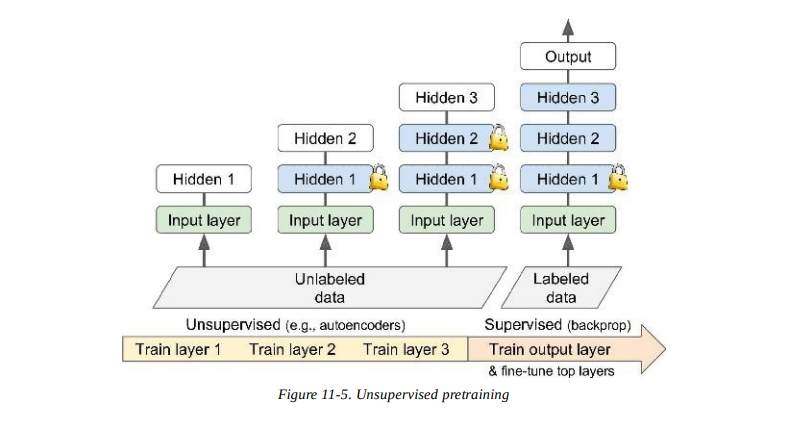

# Momentum Optimization

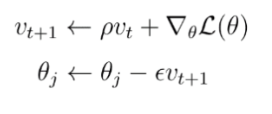

In [59]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Nestrov Accelerated Gradient

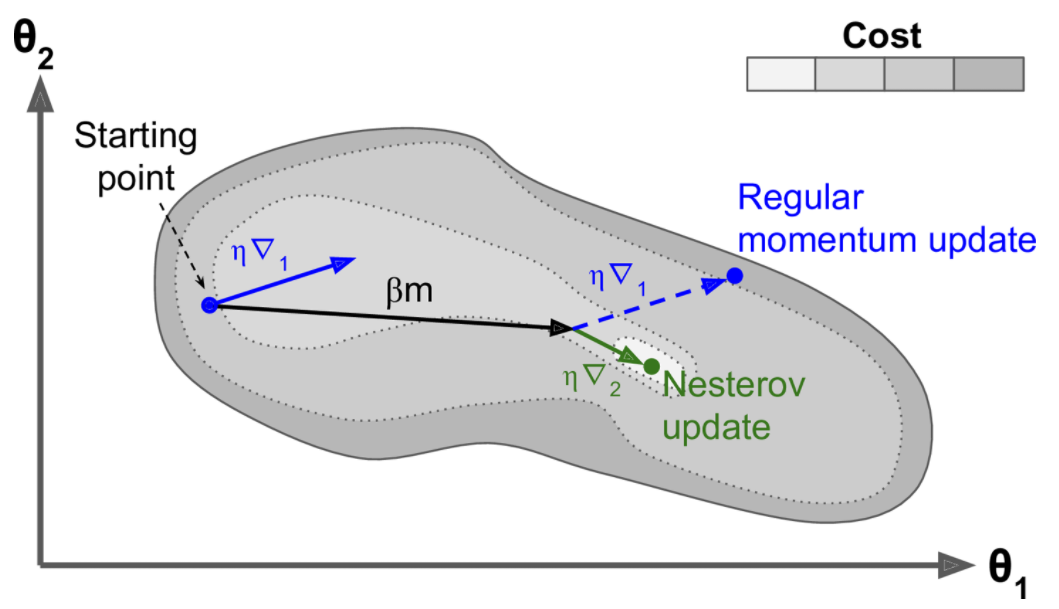

In [60]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# AdaGrad

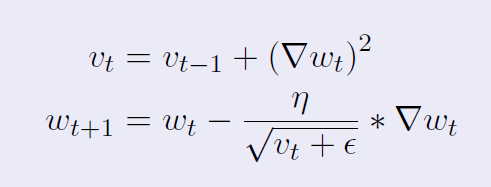

> scales down the slopes so it doesnt go down steep ones too fast

> only really useful for regression (not good with nn)

# RMSProp
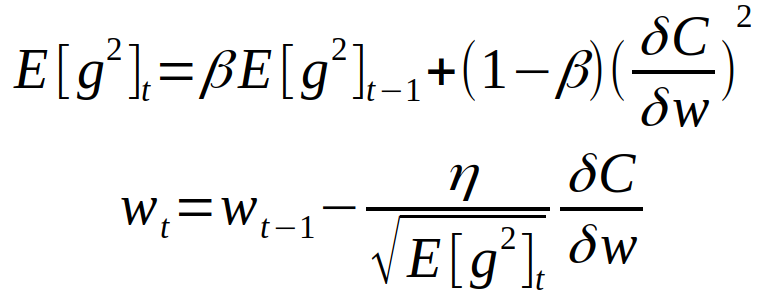

> Same as AdaGrad but use only recent gradients to compute slow and have exponetial decay of slow.

In [61]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# Adam/Nadam Optimization

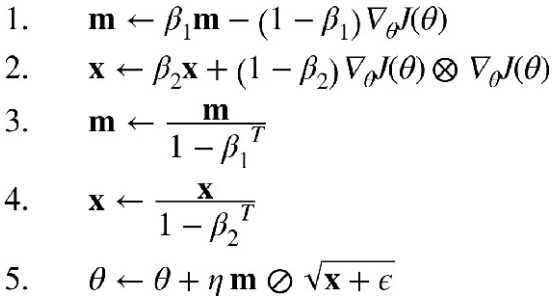

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Power Rate Sceduling

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

# Exponential Sceduling

In [64]:
def exponential_decay(lr, s):
    def exponential_decay_fn(epoch):
        return lr * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr=0.01, s=20)

In [65]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model_before.fit(
    xts, yt, epochs=1,
    validation_data=(xvs, yv),
    callbacks=[early_stopping_cb, lr_scheduler]
)

1719/1719 [==============================] - 9s 5ms/step - loss: 0.2101 - accuracy: 0.9227 - val_loss: 0.3652 - val_accuracy: 0.8956


# PieceWise Sceduling

In [66]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Performance Sceduling

In [67]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [68]:
s = 20 * len(xt) // 32 # number of steps in 20 epochs (batch size 32)

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(lr_scheduler)

# OneCycle

In [69]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [70]:
batch_size = 128
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(xt) / batch_size) * n_epochs, max_rate=0.05)

# L1 + L2 Regularization

In [71]:
layer = keras.layers.Dense(100, activation="elu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

In [72]:
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

modelr = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

# Dropout
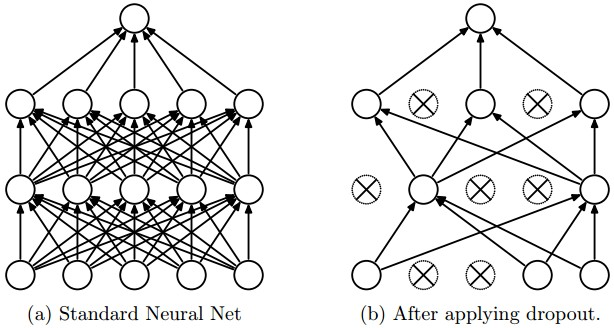

In [73]:
keras.backend.clear_session()

In [74]:
mode_drop = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal", use_bias=False),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal", use_bias=False),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(10, activation="softmax")
])

In [75]:
mode_drop.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])

In [76]:
history = mode_drop.fit(xt, yt, epochs=200,
                    validation_data=(xv, yv),
                    callbacks=[early_stopping_cb])

Epoch 1/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8512 - accuracy: 0.6912 - val_loss: 0.5263 - val_accuracy: 0.8140
Epoch 2/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6398 - accuracy: 0.7665 - val_loss: 0.4885 - val_accuracy: 0.8304
Epoch 3/200
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5959 - accuracy: 0.7838 - val_loss: 0.4636 - val_accuracy: 0.8416
Epoch 4/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5676 - accuracy: 0.7949 - val_loss: 0.4453 - val_accuracy: 0.8438
Epoch 5/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5535 - accuracy: 0.7993 - val_loss: 0.4381 - val_accuracy: 0.8476
Epoch 6/200
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5398 - accuracy: 0.8052 - val_loss: 0.4295 - val_accuracy: 0.8508
Epoch 7/200
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5290 - accuracy: 0.8067 - val_loss: 0.4219 - val_ac

In [77]:
mode_drop.evaluate(xte, yte)

313/313 [==============================] - 1s 2ms/step - loss: 0.3391 - accuracy: 0.8750


[0.3391348421573639, 0.875]

> Consider "Alpha Dropout" to use with SELU

# Monte Carlo Dropout

In [78]:
y_probas = np.stack([mode_drop(xts, training=True)
                   for sample in range(100)])
y_probs = y_probas.mean(axis=0)

In [79]:
np.round(mode_drop.predict(xts[:1]), 2)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [80]:
np.round(y_probas[:,:1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0

In [81]:
np.round(y_probs[:1], 2)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [82]:
# accuracy = np.sum(y_pred == y_test) / len(y_test)

In [83]:
class McDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Max

In [84]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", 
                   kernel_constraint=keras.constraints.max_norm(1.))

# Summary

> Default DNN (he_normal, ELU, (BatchNorm if Deep), Early Stopping, Adam, 1cycle)

> Sequential Stack (LeCun, SELU, Alpha Dropout, Adam, 1cycle)